In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch


In [67]:
# SIMPLE GD

# Extract data_theta, doesn't matter what image is extracted since we're just getting theta
DATA = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_temp_sweep/image_theta.npz')['data']
# DATA = np.load('/Users/yucongchen/billingegroup/skyrmion_lattices/skyrmion-lattices-data/image_111001.npz')['data']
DATA_THETA = torch.atan2(torch.tensor(DATA[1]), torch.tensor(DATA[0]))
resolution = 10.8 #degrees
offset = torch.tensor(0., requires_grad=True)
intensity_data = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_temp_sweep/121855.npz')['data']
print(intensity_data.shape)

# for the model
MAX_ITER_OFFSET = 101
LR = 1e-2

n_folds = 6
def filter_function(k, theta, n_folds=n_folds):
    filter = torch.exp(k * torch.log((torch.cos(n_folds / 2 * theta))**2))
    return filter

def k_val(fwhm):
    '''fwhm is your resolution given in degrees.

    This is derived based off the assumption that FWHM for the cosine 
    is approximately equal to a gaussian, which is a good assumption for this case
    Because FWHM for the cosine filter is approx equal to FWHM for a gaussian'''
    fwhm = np.deg2rad(fwhm)
    k = np.log(1/2) / (np.log(np.cos(3/2*fwhm)**2))
    return k

k = k_val(resolution)
print('k =', k)

def gradient_descent_optimize_offset(intensity, offset, k=k):
    intensity = torch.tensor(intensity)
    opt = torch.optim.Adam([offset], lr=LR)
    for i in range(MAX_ITER_OFFSET):
        evaluate_image_theta = filter_function(k, DATA_THETA+offset)
        loss = -(intensity * evaluate_image_theta).sum()
        opt.zero_grad()
        loss.backward()
        opt.step()
    return offset, evaluate_image_theta, loss

offset_list = []
for i in range(1):
    offset, im, loss = gradient_descent_optimize_offset(intensity_data[i], offset)
    # offset tuple gives the angular position of each intensity peak from 0 to 360deg
    print((np.rad2deg(offset.detach().numpy())))
    offset_tuple = tuple((np.rad2deg(offset.detach().numpy()) + 60 * j) % 360 for j in range(6))
    offset_list.append(offset_tuple)
    print(offset_tuple)

print(10 % 20)

(60, 128, 128)
k = 8.553968178278982
-16.638062
(343.3619384765625, 43.3619384765625, 103.3619384765625, 163.3619384765625, 223.3619384765625, 283.3619384765625)
10


(360,)


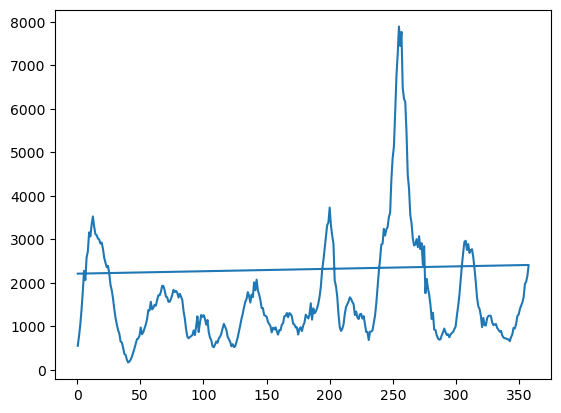

In [48]:
def radial_intensity_profile(image, num_bins=360):
    '''Creates theta vs. intensity while accounting for rotational wrap-around.'''
    # Define image center
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
    
    # Create arrays for pixel coordinates
    y, x = np.indices((image.shape))
    x -= center_x
    y -= center_y
    
    # Calculate polar coordinates
    theta = np.arctan2(y, x)  # in radians
    r = np.hypot(x, y)

    # Convert theta to degrees and shift range to [0, 360]
    theta_deg = np.degrees(theta)
    theta_deg = (theta_deg + 360) % 360

    # Bin intensities by angle
    intensity_sum, theta_edges = np.histogram(theta_deg, bins=num_bins, weights=image)
    
    # Wrap around the last bin to the first bin
    intensity_sum[0] += intensity_sum[-1]
    intensity_sum = intensity_sum[:-1]  # Remove the last bin after combining
    
    # Calculate bin centers
    theta_centers = (theta_edges[1:] + theta_edges[:-1]) / 2
    theta_centers = theta_centers[:-1]  # Match length with intensity_sum

    # Ensure the plot wraps around by appending the first point to the end
    theta_centers = np.append(theta_centers, theta_centers[0])
    intensity_sum = np.append(intensity_sum, intensity_sum[0])

    return theta_centers, intensity_sum


stdev_list = []
smoothed_int_list = []
for i in range(1):
    theta, intensity = radial_intensity_profile(intensity_data[i])
    
    # Optional smoothing
    intensity_smoothed = np.convolve(intensity, [.1, .2, .3, .4, 0.5, .6, .7, .8, .9, 1], mode='same')
    smoothed_int_list.append(intensity_smoothed)
    print(intensity_smoothed.shape)
    # Plot the original and smoothed intensity profiles
    plt.plot(theta, intensity_smoothed, label="Smoothed Intensity")
    stdev_list.append(np.std(intensity_smoothed))
    # plt.show()

    # plt.plot(theta, intensity, alpha=0.3, label="Original Intensity")

In [58]:
def calculate_angular_std(intensity_sum, peak_positions, theta_centers=None, num_points=5):
    '''
    Calculates the standard deviations of angular positions around known peaks.
    
    Parameters:
    - intensity_sum: Array of intensity values.
    - peak_positions: List of 6 known peak positions (in degrees).
    - theta_centers: Array of theta values (optional).
    - num_points: Number of data points to consider on each side of the peak.
    
    Returns:
    - List of standard deviations for the angular positions around each peak.
    '''
    # Generate theta values based on the size of input data if not provided
    if theta_centers is None:
        theta_centers = np.linspace(0, 360, num=len(intensity_sum), endpoint=False)
    
    intensity_sum = np.array(intensity_sum)
    num_bins = len(intensity_sum)
    std_devs = []
    
    # Convert peak positions from degrees to indices
    peak_indices = [(int((pos / 360) * num_bins) % num_bins) for pos in peak_positions]
    print(peak_indices)
    for peak_idx in peak_indices:
        # Determine the range of indices around the peak (with wrap-around)
        indices = [(peak_idx + i) % num_bins for i in range(-num_points, num_points + 1)]
        
        # Extract the angles and corresponding intensities
        theta_region = theta_centers[indices]
        intensity_region = intensity_sum[indices]
        
        # Calculate the weighted mean angle
        weighted_mean_theta = np.average(theta_region, weights=intensity_region)
        
        # Calculate the angular standard deviation
        angular_diffs = np.abs(theta_region - weighted_mean_theta)
        angular_diffs = np.where(angular_diffs > 180, 360 - angular_diffs, angular_diffs)
        std_dev = np.sqrt(np.average(angular_diffs**2, weights=intensity_region))
        std_devs.append(std_dev)
    
    return std_devs



In [71]:
calculate_angular_std(smoothed_int_list[0],[20, 75, 140, 190, 255, 315], num_points=20)


[20, 75, 140, 190, 255, 315]


[8.76518244568141,
 10.807963834335933,
 10.005895469648523,
 10.449326035761063,
 9.60100668282068,
 9.948611681268806]

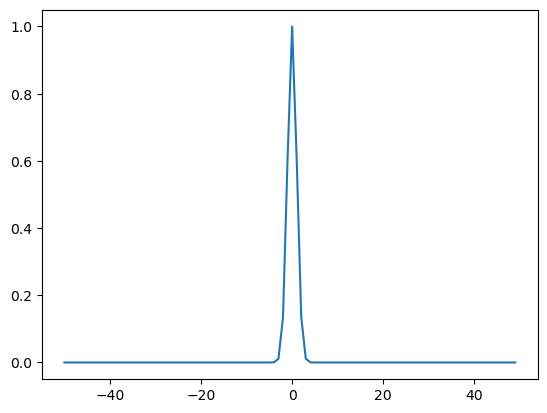

0.1307595255070346


In [82]:
import numpy as np
import matplotlib.pyplot as plt

def gaus(x, sigma, amplitude=1):
    # Unnormalized Gaussian function
    return amplitude * np.exp(-(x)**2 / (2 * sigma**2))

x = np.arange(-50, 50)
y = gaus(x, 1, amplitude=1)

plt.plot(x, y)
plt.show()

# Now the standard deviation of the unnormalized Gaussian should be close to 10
print(np.std(y))
